In [1]:
import math

import optuna

from gnn_tracking.models.mlp import MLP
from torch import Tensor
from torch import nn


class MetricLearningGraphConstruction(nn.Module):
    def __init__(self, *, node_indim: int, outdim: int = 12, n_layers: int, layer_width: int):
        super().__init__()
        self.encoder = MLP(node_indim, layer_width, layer_width, L=n_layers, include_last_activation=True)
        self.beta_nn = MLP(layer_width, 1, layer_width, L=1)
        self.latent = MLP(layer_width, outdim, layer_width, L=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, data) -> dict[str, Tensor]:
        h = self.encoder(data.x)
        r = {
            "H": self.latent(h),
            "B": self.sigmoid(self.beta_nn(h)).squeeze(),
        }
        return r

%load_ext autoreload
%autoreload 2


In [2]:
from gnn_tracking.utils.loading import TrackingDataset, get_loaders

ds = TrackingDataset(
    [
        f"/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_{i}"
        for i in range(1, 9)
    ]
)
val_ds = TrackingDataset(
    "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v5/part_9"
)
loaders = get_loaders({"train": ds, "val": val_ds}, batch_size=1, max_sample_size=1_000)

[15:46:26] INFO: DataLoader will load 7743 graphs (out of 7743 available).
[15:46:26] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v2/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v2/part_8/data28999_s0.pt
[15:46:26] INFO: DataLoader will load 1000 graphs (out of 1000 available).
[15:46:26] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v2/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v2/part_9/data29999_s0.pt
[15:46:26] DEBUG: Parameters for data loader 'train': {'batch_size': 1, 'num_workers': 1, 'sampler': <torch.utils.data.sampler.RandomSampler object at 0x14ddc642dd20>, 'pin_memory': True, 'shuffle': None}
[15:46:26] DEBUG: Parameters for data loader 'val': {'batch_size': 1, 'num_workers': 1, 'sampler': None, 'pin_memory': True, 'shuffle': False}


In [3]:

from functools import partial
from gnn_tracking.postprocessing.dbscanscanner import dbscan_scan, dbscan
from gnn_tracking.metrics.losses import PotentialLoss, BackgroundLoss

loss_functions = {
    "potential": (PotentialLoss(q_min=0.01, radius_threshold=3), {"attractive": 100, "repulsive": 1}),
    "background": (BackgroundLoss(sb=1), 0.005),
}



In [4]:
from gnn_tracking.training.tcn_trainer import TCNTrainer
from gnn_tracking.graph_construction.radius_scanner import RadiusScanner
%aimport gnn_tracking.analysis.graphs
import torch

class GCTrainer(TCNTrainer):
    @torch.no_grad()
    def test_step(self, val=True, max_batches: int | None = None) -> dict[str, float]:
        self.save_checkpoint()
        if max_batches is None:
            max_batches = 1
        else:
            max_batches = min(max_batches, 1)
        self.model.eval()
        loader = self.val_loader if val else self.test_loader
        assert loader is not None
        mos = []
        for _batch_idx, data in enumerate(loader):
            if max_batches and _batch_idx > max_batches:
                break
            data = data.to(self.device)  # noqa: PLW2901
            mos.append(self.evaluate_model(
                data,
                mask_pids_reco=False,
            ))
        rs = RadiusScanner(
            model_output=mos,
            radius_range=(0.1, 3),
            max_num_neighbors=128,
            n_trials=10,
            target_fracs=(0.8, 0.9, 0.95),
            max_edges=8_000_000,
        )
        rs.logger.setLevel(logging.DEBUG)
        rsr = rs()
        self._rsr = rsr
        return rsr.get_foms()

In [5]:
trainer = GCTrainer(MetricLearningGraphConstruction(node_indim=7, n_layers=6, layer_width=256), loaders, loss_functions, lr=1e-3, cluster_functions={})

[15:46:27 TCNTrainer] INFO: Using device cuda


In [6]:
# from pathlib import Path
# data = trainer.val_loader.dataset[0]
# import logging
# for p in list(Path(".").glob("230526_*")):
#     trainer.load_checkpoint(p)
#     mo = trainer.evaluate_model(data)
#     rs = RadiusScanner(
#         model_output=[mo],
#         radius_range=(0.01, 3),
#         max_num_neighbors=128,
#         n_trials=5,
#         target_fracs=(0.5, 0.65),
#         max_edges=5_000_000,
#     )
#     rs.logger.setLevel(logging.ERROR)
#     rsr = rs()
#     print(rsr.get_foms())

In [7]:
trainer.loss_functions = loss_functions

In [8]:
trainer.load_checkpoint("230529_121432_model.pt")

In [26]:
trainer.train()

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
[12:16:29 TCNTrainer] DEBUG: Epoch 16 (    0/1000): Total=   0.01705, potential_attractive=   0.00554, potential_repulsive=   0.00652, background=   0.00500 (weighted)
[12:16:30 TCNTrainer] DEBUG: Epoch 16 (   10/1000): Total=   0.01840, potential_attractive=   0.00634, potential_repulsive=   0.00705, background=   0.00500 (weighted)
[12:16:31 TCNTrainer] DEBUG: Epoch 16 (   20/1000): Total=   0.01543, potential_attractive=   0.00429, potential_repulsive=   0.00614, background=   0.00500 (weighted)
[12:16:32 TCNTrainer] DEBUG: Epoch 16 (   30/1000): Total=

KeyboardInterrupt: 

In [7]:
data = trainer.val_loader.dataset[0]

<Axes: >

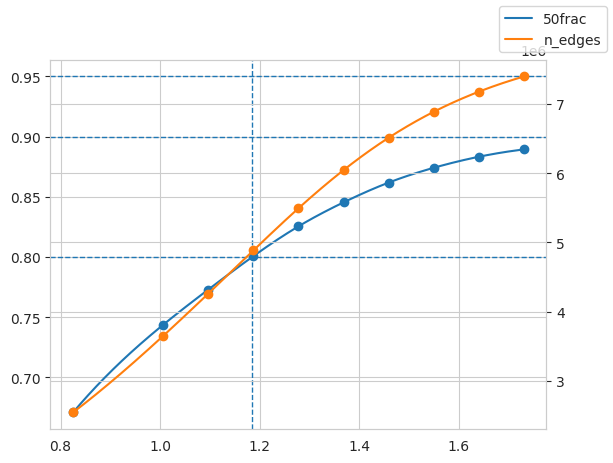

In [27]:
trainer._rsr.plot()

In [8]:
from gnn_tracking.graph_construction.radius_scanner import construct_graph

mo = trainer.evaluate_model(data)

In [10]:
rs = RadiusScanner(
    model_output=[mo],
    radius_range=(0.01, 3),
    max_num_neighbors=128,
    n_trials=5,
    target_fracs=(0.5, 0.65),
    max_edges=5_000_000,
)
rsr = rs()

[11:48:01 RadiusHP] DEBUG: Updated max radius to 1.505000 (too many edges)
[11:48:01 RadiusHP] DEBUG: Updated max radius to 0.757500 (too many edges)
[11:48:03 RadiusHP] DEBUG: Radius 0.383750 -> 50-segment: 0.680987, edges: 2329317.000000
[11:48:03 RadiusHP] DEBUG: Updated max radius to 0.383750 (overachieving)
[11:48:06 RadiusHP] DEBUG: Radius 0.196875 -> 50-segment: 0.396752, edges: 678122.000000
[11:48:06 RadiusHP] DEBUG: Updated min radius to 0.196875 (underarchieving)
[11:48:09 RadiusHP] DEBUG: Radius 0.290313 -> 50-segment: 0.558624, edges: 1391638.000000
[11:48:12 RadiusHP] DEBUG: Radius 0.243594 -> 50-segment: 0.485232, edges: 1005968.000000
[11:48:12 RadiusHP] DEBUG: Updated min radius to 0.243594 (underarchieving)
[11:48:14 RadiusHP] DEBUG: Radius 0.337031 -> 50-segment: 0.623194, edges: 1833990.000000
[11:48:14 RadiusHP] INFO: Finished radius scan in 13s.


In [ ]:
from torch_cluster import radius_graph
from torch_geometric.data import Data


In [ ]:
from typing import Any



In [18]:
import networkx as nx
import numpy as np
import torch_geometric
import torch



In [21]:
def summarize_ls(ls):
    return {
        "frac_segment50": np.mean(ls > 0.5),
        "frac_segment75": np.mean(ls > 0.75),
        "frac_segment100": np.mean(ls == 1.0),
    }

In [ ]:
mo

In [ ]:
print(get_largest_segment_fracs(construct_graph(mo, 1)))

In [22]:
from gnn_tracking.analysis.graphs import get_largest_segment_fracs
import pandas as pd
from tqdm import tqdm

stats = []
rs = np.linspace(0.3, 2, 5)
for r in tqdm(rs):
    data = construct_graph(mo, r)
    stats.append(summarize_ls(get_largest_segment_fracs(data)) | {"n_edges": data.num_edges, "r": r})
stats = pd.DataFrame.from_records(stats)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.31s/it]


In [ ]:
stats.to_dict()

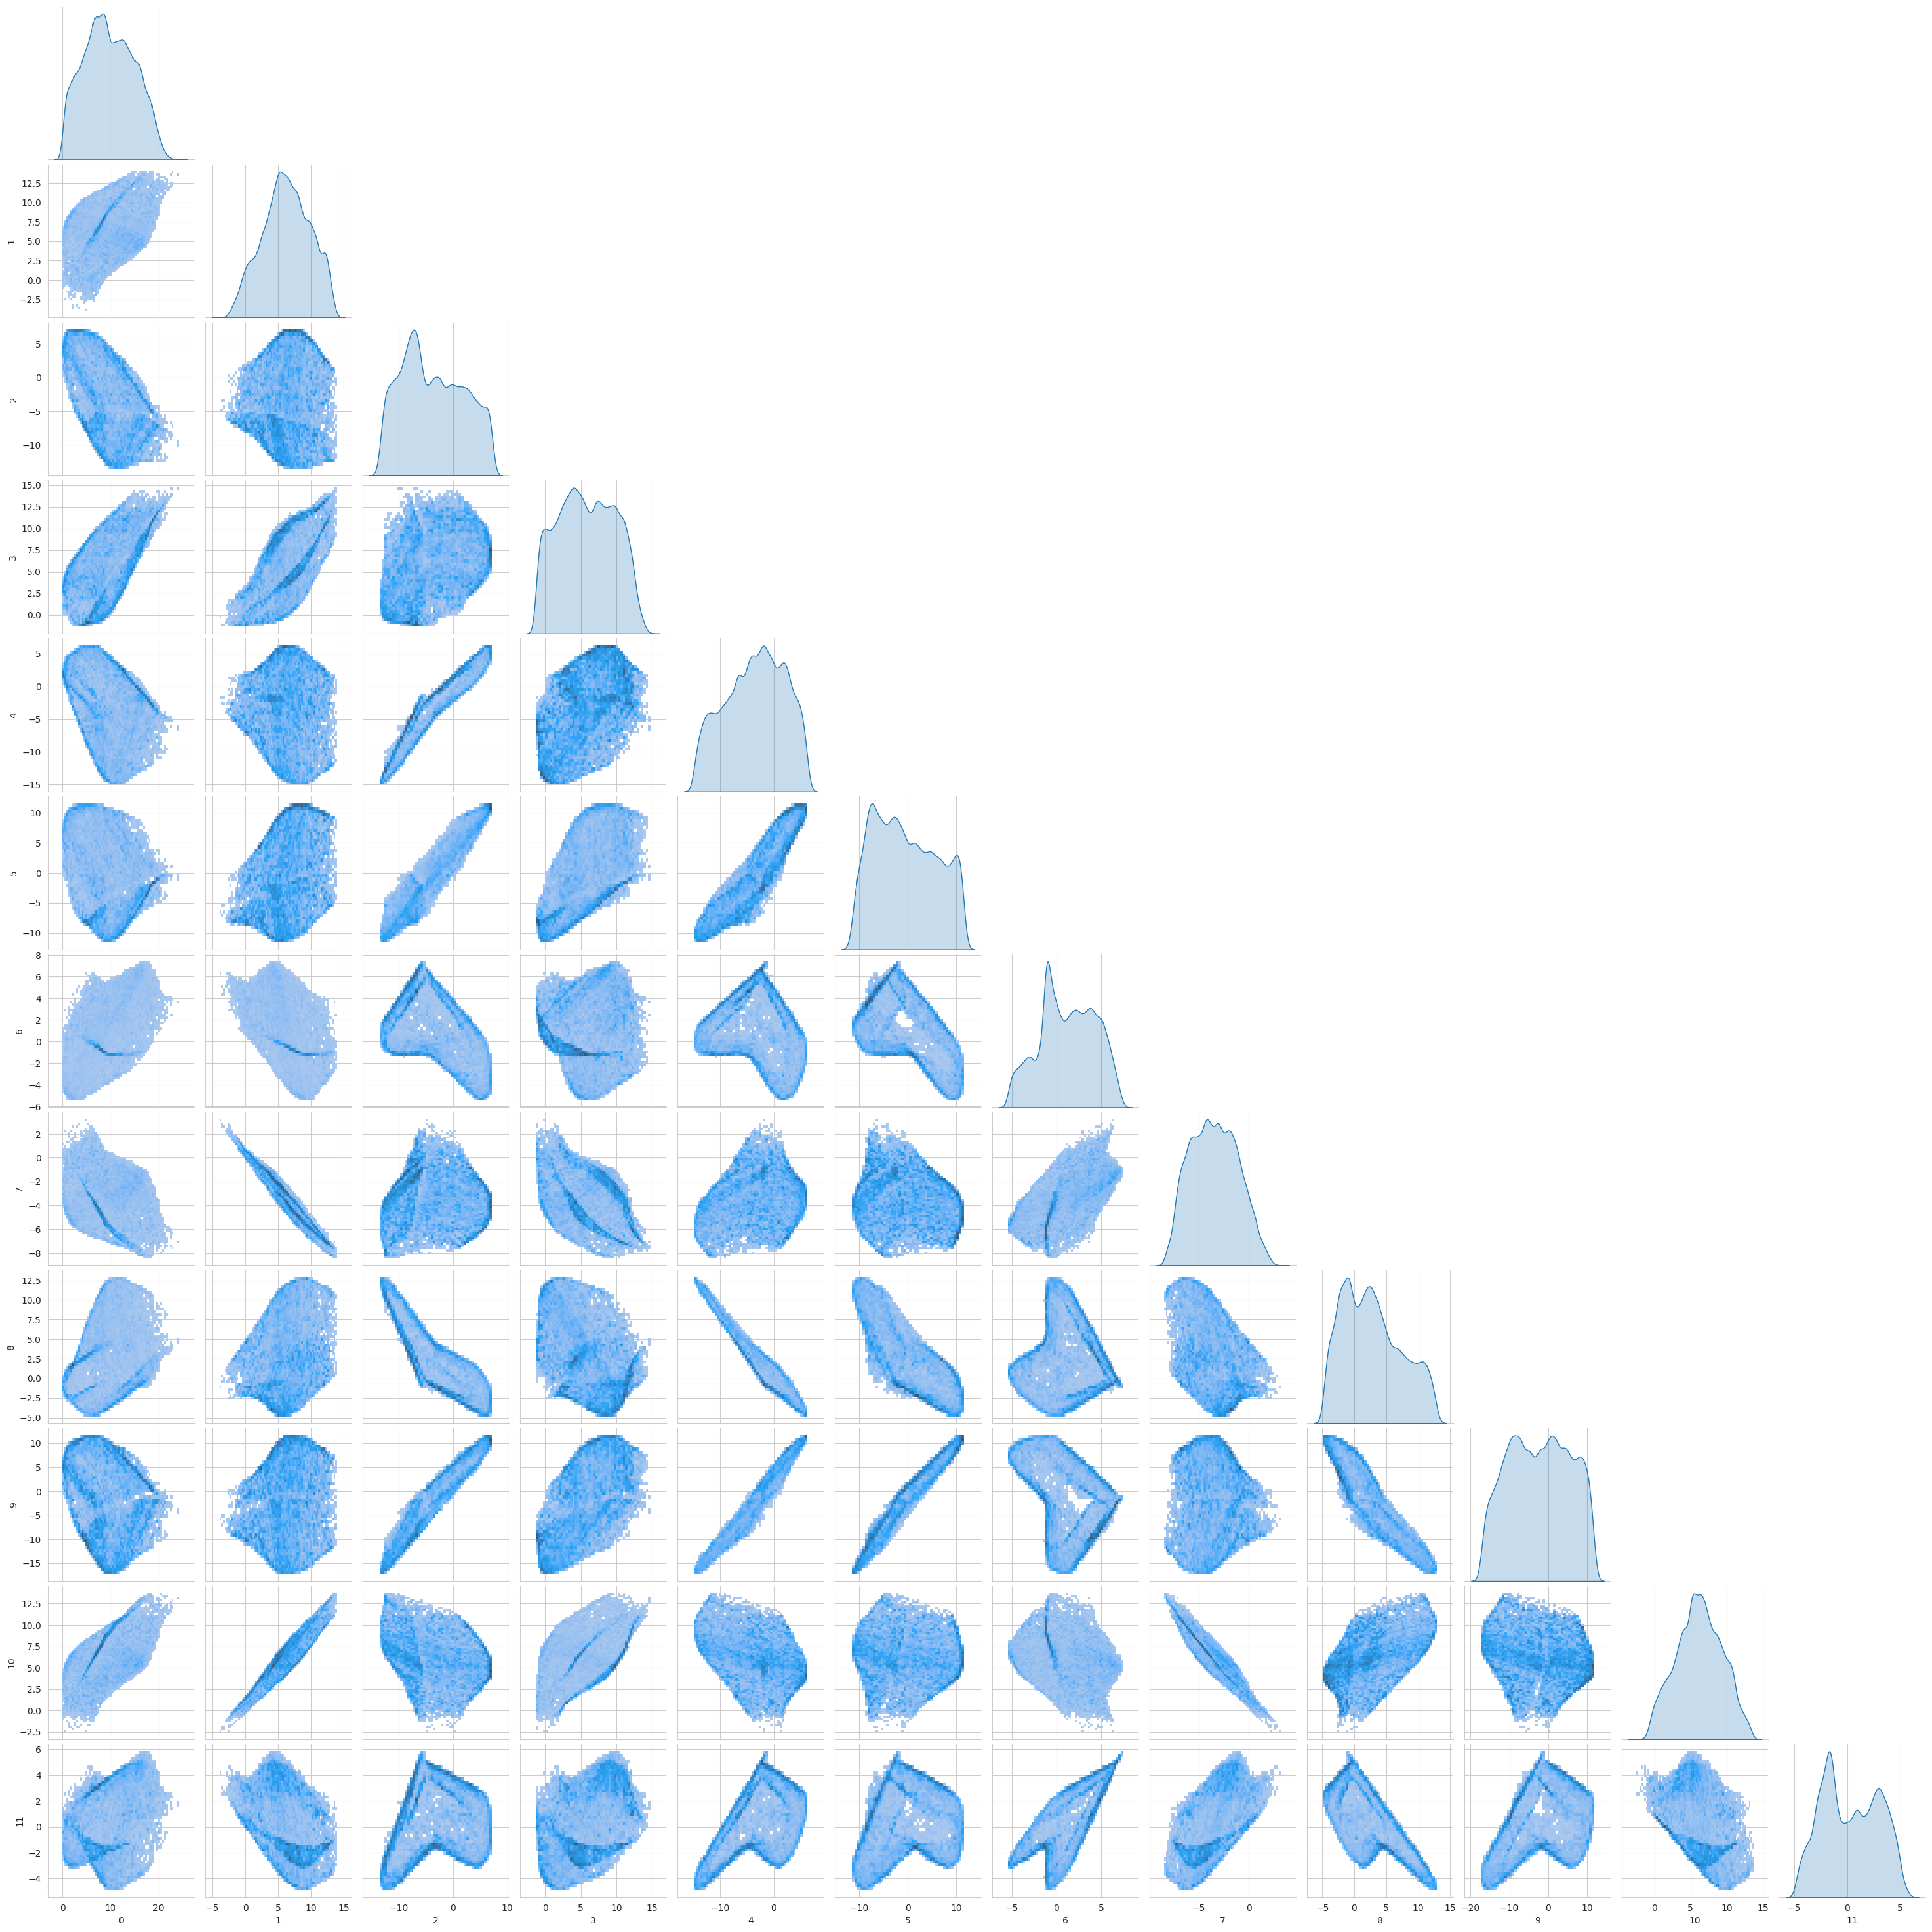

In [19]:
x = mo["x"].detach().cpu().numpy()
import seaborn as sns
sns.pairplot(pd.DataFrame(x), corner=True, diag_kind="kde", kind="hist")

Text(0.5, 0, 'radius')

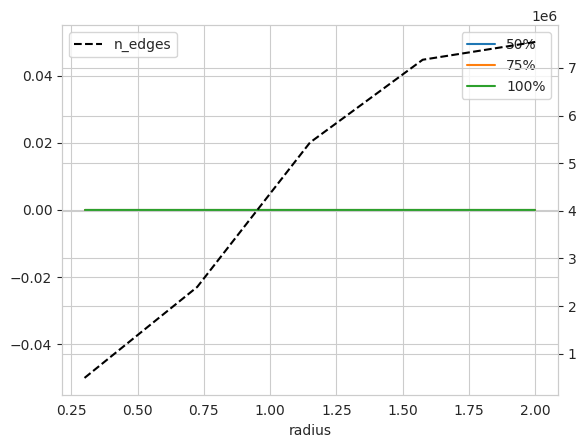

In [23]:
import matplotlib.pyplot as plt
# plt.style.use("/home/kl5675/Documents/23/git_sync/klieret-gnn-tracking-experiments/notebooks/sss1.mplstyle")

fig, ax = plt.subplots()
ax.plot("r", "frac_segment50", data=stats, label="50%")
ax.plot("r", "frac_segment75", data=stats, label="75%")
ax.plot("r", "frac_segment100", data=stats, label="100%")
ax2 = ax.twinx()
ax2.plot("r", "n_edges", data=stats, label="n_edges", color="k", linestyle="dashed")
ax.legend()
ax2.legend()
ax.set_xlabel("radius")

In [ ]:
data.num_edges / 1e6

In [ ]:
t()
summarize_ls(get_largest_segments(data)), t()

In [ ]:
from gnn_tracking.utils.timing import Timer
import collections

t = Timer()
r = collections.defaultdict(list)

t()

In [ ]:
r

In [ ]:
gxx = nx.Graph([(1, 2), (2, 3), (5, 6)])

In [ ]:
list(nx.connected_components(gxx))

In [ ]:
r

In [ ]:
gx_sg.number_of_nodes()

In [ ]:
%aimport gnn_tracking.analysis.graphs
from gnn_tracking.analysis.graphs import get_all_graph_construction_stats


t()
r = get_all_graph_construction_stats(data.to("cuda"))
t()

In [ ]:
r

In [ ]:
from gnn_tracking.utils.graph_masks import get_edge_mask_from_node_mask
from gnn_tracking.metrics.binary_classification import BinaryClassificationStats
import torch

bcs = BinaryClassificationStats(
    output=torch.ones_like(data.y).long(), y=data.y.long(), thld=0.0
)
pt_edge_mask = get_edge_mask_from_node_mask(data.pt > 0.9, data.edge_index)
bcs_thld = BinaryClassificationStats(
    output=torch.ones_like(data.y[pt_edge_mask]).long(),
    y=data.y[pt_edge_mask].long(),
    thld=0.0,
)

In [ ]:
bcs.get_all()

In [ ]:
57038 / (57038 + 1888278)